In [2]:
print("Python běží!")

Python běží!


In [3]:
import sys

#sys.path.append('../')

!{sys.executable} -m pip install -r ./pip-dependencies.txt

Defaulting to user installation because normal site-packages is not writeable


# Generování signálu
Tento program vygenruje audio signálay, přehraje je, nahraje odezvu a zobrazí spektra.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pyaudio
import datetime
from scipy.fft import fft
from colors import *

In [5]:
# Parametry
Fs = 48000  # vzorkovací frekvence
N = 48000  # počet vzorků
T = 5  # čas testu v sekundách
G = 0.45  # zesílení

# Frekvence
f1 = 2000
f2 = 6000

BUFFER_SIZE = 1024

# Inicializace PyAudio
audio = pyaudio.PyAudio()

ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_route.c:878:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:878:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:878:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:878:(find_matching_chmap) Found no matching channel map
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
Jac

In [6]:
# Prohledani vsech zvukovych zarizeni
def get_audio_devices(audio):
    for i in range(audio.get_device_count()):
        dev = audio.get_device_info_by_index(i)
        """
        print("Divece index: ", Blue + str(i) + NC)
        print(" |- Device name: ", Blue + dev['name'] + NC)
        print(" |- Max input channels:  ", Blue + str(dev['maxInputChannels']) + NC)
        print(" |- Max output channels: ", Blue + str(dev['maxOutputChannels']) + NC)
        """
        print((i, dev['name'], dev['maxInputChannels'], dev['maxOutputChannels']))

VALID_AUDIO_DEVICES = [
    'USB AUDIO DEVICE: Audio (hw:1,0)', 
    'Zvukový mixér (Realtek(R) Audio)'
]

def is_valid_audio_device(device_name):
    for valid_device in VALID_AUDIO_DEVICES:
        if valid_device in device_name:
            return True
    return False

# Získání ID vstupního a výstupního zařízení
def get_audio_id(audio):
    input_id = None
    output_id = None
    for i in range(audio.get_device_count()):
        dev = audio.get_device_info_by_index(i)
        if is_valid_audio_device(dev['name']):
            if dev['maxInputChannels'] > 0:
                input_id = dev['index']
            if dev['maxOutputChannels'] > 0:
                output_id = dev['index']
    return input_id, output_id

# Funkce pro vykreslení amplitudového spektra
def ampl_spectr(signal, N, Fs, title, max_freq=10000, max_amp=1):
    Y = fft(signal, N)
    Y = np.abs(Y[:N//2])
    f = np.linspace(0, Fs/2, N//2)
    plt.plot(f, Y)
    plt.xlim(0, max_freq)
    plt.ylim(0, max_amp)
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid()

# Python generator, yielduje bloky dat
def bin_data_block_generator(signal: np.array , Fs: int, T: int, buffer_size: int=BUFFER_SIZE):
    """ Generator pro posílání bloků dat

    Args:
        signal (np.array): signál
        Fs (int): vzorkovací frekvence
        T (int): délka signálu v sekundách
        buffer_size (int): velikost bloku

    Yields:
        bytes: blok dat
    """
    def to_bytes(signal) -> bytes:
        return signal.astype(np.float32).tobytes()
    
    def next_block(signal, i) -> np.array:
        block_start_index = i * buffer_size
        block_end_index = (i + 1) * buffer_size
        return signal[block_start_index:block_end_index, :]

    number_of_blocks = int(Fs / buffer_size * T)
    for i in range(0, number_of_blocks):
        yield to_bytes(next_block(signal, i))

In [7]:
get_audio_devices(audio)

(0, 'HDA Intel PCH: ALC298 Analog (hw:0,0)', 2, 4)
(1, 'HDA Intel PCH: HDMI 0 (hw:0,3)', 0, 8)
(2, 'HDA Intel PCH: HDMI 1 (hw:0,7)', 0, 8)
(3, 'HDA Intel PCH: HDMI 2 (hw:0,8)', 0, 8)
(4, 'USB AUDIO DEVICE: Audio (hw:1,0)', 2, 2)
(5, 'sysdefault', 128, 128)
(6, 'front', 0, 4)
(7, 'surround40', 0, 4)
(8, 'surround51', 0, 4)
(9, 'surround71', 0, 4)
(10, 'hdmi', 0, 8)
(11, 'lavrate', 128, 128)
(12, 'samplerate', 128, 128)
(13, 'speexrate', 128, 128)
(14, 'pipewire', 64, 64)
(15, 'pulse', 32, 32)
(16, 'speex', 1, 1)
(17, 'upmix', 8, 8)
(18, 'vdownmix', 6, 6)
(19, 'dmix', 0, 2)
(20, 'default', 64, 64)


In [28]:
get_audio_id(audio)

(4, 4)

In [29]:
ID_input, ID_output = get_audio_id(audio)

ID_input = -1
ID_output = 4

# Generování signálů
t = np.arange(0, T, 1/Fs)
x_left = G * np.cos(2 * np.pi * f1 * t)
x_right = G * np.cos(2 * np.pi * f2 * t)

# Stereo signál
x_LR = np.column_stack((x_left, x_right))


Text(0.5, 0, 'Time (s)')

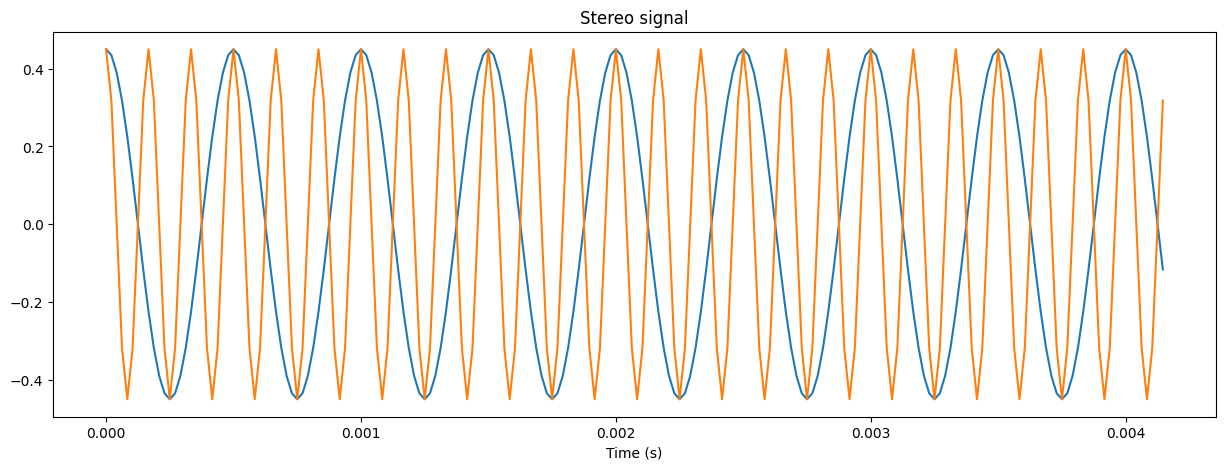

In [18]:
# signal plot
plt.figure(figsize=(15, 5))
n = 200
plt.plot(t[:n], x_left[:n], label='Left channel')
plt.plot(t[:n], x_right[:n], label='Right channel')
plt.title('Stereo signal')
plt.xlabel('Time (s)')

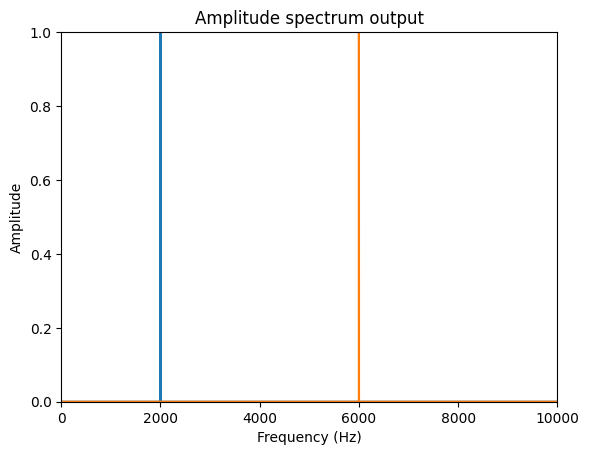

In [19]:
ampl_spectr(x_left, N, Fs, 'Amplitude spectrum output')
ampl_spectr(x_right, N, Fs, 'Amplitude spectrum output')

In [30]:
# Přehrávání a nahrávání
print("Start...")
tStart = datetime.datetime.now()

stream_out = audio.open(format=pyaudio.paInt24,
                    channels=2,
                    rate=Fs,
                    output=True,
                    output_device_index=ID_output)

stream_in = audio.open(format=pyaudio.paInt24,
                   channels=2,
                   rate=Fs,
                   input=True,
                   input_device_index=ID_input)


# Přehrávání a nahrávání
frames = []

print("Playing and recording...")
for data in bin_data_block_generator(x_LR, Fs, T):
    stream_out.write(data)
    data = stream_in.read(BUFFER_SIZE)
    frames.append(data)

print("Stop...")

# Ukončení streamů
stream_out.stop_stream()
stream_out.close()
stream_in.stop_stream()
stream_in.close()

Start...
Playing and recording...
Stop...


Ploting results...


<Figure size 640x480 with 0 Axes>

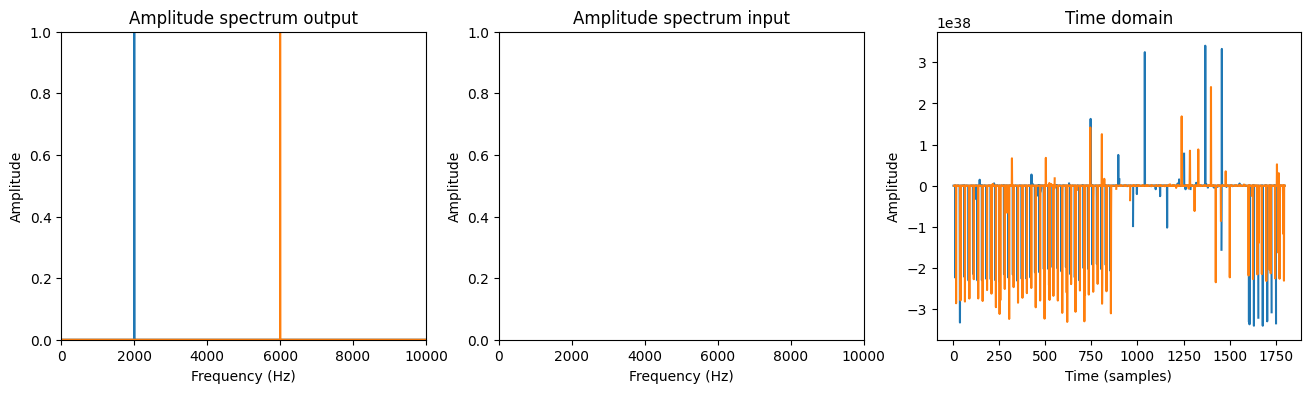

duration of the experiment: 0:00:09.534969
Done.


In [31]:
print("Ploting results...")
# Zpracování nahraných dat
y12o = np.frombuffer(b''.join(frames), dtype=np.float32).reshape(-1, 2)
y12 = y12o[Fs:2*Fs, :]

y1 = y12[:, 0]
y2 = y12[:, 1]

# Vykreslení výsledků
plt.figure()
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
ampl_spectr(x_left, N, Fs, 'Amplitude spectrum output')
ampl_spectr(x_right, N, Fs, 'Amplitude spectrum output')
plt.subplot(1, 3, 2)
ampl_spectr(y1, N, Fs, 'Amplitude spectrum input')
ampl_spectr(y2, N, Fs, 'Amplitude spectrum input')

plt.subplot(1, 3, 3)
number_of_samples = 1800
plt.plot(y1[:number_of_samples])
plt.plot(y2[:number_of_samples])
plt.title('Time domain')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()

print(f"duration of the experiment: {datetime.datetime.now() - tStart}")
print(Green + "Done." + NC)

Start...
...playing...
...recording...


/home/pytel/.local/lib/python3.12/site-packages/matplotlib/cbook.py:1398: RuntimeWarning: invalid value encountered in cast
  return np.asarray(x, float)


<Figure size 640x480 with 0 Axes>

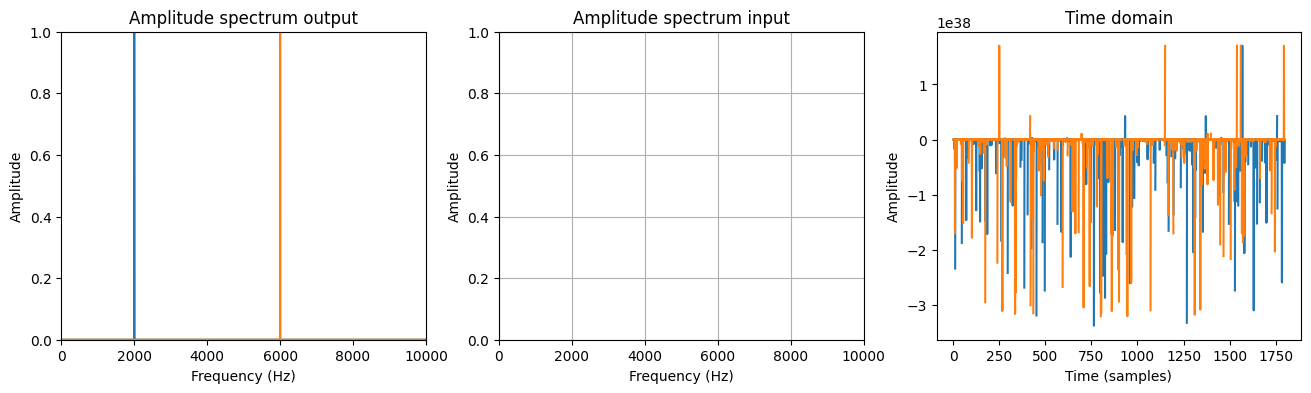

duration of the experiment: 0:00:09.391242
Done.


In [51]:
# Přehrávání a nahrávání
print("Start...")
tStart = datetime.datetime.now()

# Přehrávání a nahrávání
print("...playing...")
stream_out.write(x_LR.astype(np.float32).tobytes())

print("...recording...")
frames = []
for _ in range(0, int(Fs / 1024 * 2)):
    data = stream_in.read(1024)
    frames.append(data)

# Ukončení streamů
stream_out.stop_stream()
stream_out.close()
stream_in.stop_stream()
stream_in.close()

# Zpracování nahraných dat
y12o = np.frombuffer(b''.join(frames), dtype=np.float32).reshape(-1, 2)
y12 = y12o[Fs:2*Fs, :]

y1 = y12[:, 0]
y2 = y12[:, 1]

# Vykreslení výsledků
plt.figure()
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
ampl_spectr(x_left, N, Fs, 'Amplitude spectrum output')
ampl_spectr(x_right, N, Fs, 'Amplitude spectrum output')
plt.subplot(1, 3, 2)
ampl_spectr(y1, N, Fs, 'Amplitude spectrum input')
ampl_spectr(y2, N, Fs, 'Amplitude spectrum input')

plt.subplot(1, 3, 3)
number_of_samples = 1800
plt.plot(y1[:number_of_samples])
plt.plot(y2[:number_of_samples])
plt.title('Time domain')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()

print(f"duration of the experiment: {datetime.datetime.now() - tStart}")
print(Green + "Done." + NC)

In [10]:
# Ukončení streamů
stream_out.stop_stream()
stream_out.close()
stream_in.stop_stream()
stream_in.close()
audio.terminate()